In [1]:
## load libraries
suppressWarnings(suppressPackageStartupMessages(library(ggthemes)))
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(scran)))
suppressWarnings(suppressPackageStartupMessages(library(Rtsne)))

In [4]:
# load data (sceset)

In [2]:
sce = readRDS("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/merged/20180618/sce_merged_afterqc_filt_allexpts.rds")

In [3]:
sce

class: SingleCellExperiment 
dim: 11231 36044 
metadata(4): log.exprs.offset log.exprs.offset log.exprs.offset
  log.exprs.offset
assays(3): tpm counts logcounts
rownames(11231): ENSG00000000003_TSPAN6 ENSG00000000419_DPM1 ...
  ENSG00000272325_NUDT3 ENSG00000272398_CD24
rowData names(17): exprs_collapsed_to ensembl_transcript_id ...
  is_intop2000hvg is_hvg
colnames(36044): 21843_1#10 21843_1#100 ... 24539_8#97 24539_8#98
colData names(123): adj_x adj_y ... princ_curve princ_curve_scaled01
reducedDimNames(1): PCA
spikeNames(1): ERCC

In [5]:
## highly variable genes (HVGs)

In [6]:
sce = normalize(sce)
design = model.matrix(~ experiment, data = colData(sce)) # batches
alt.fit = trendVar(sce, design = design, use.spikes = FALSE)
alt.decomp = decomposeVar(sce, alt.fit)

Warning message in .local(object, ...):
“spike-in transcripts in 'ERCC' should have their own size factors”

In [7]:
## top 500 HVGs

In [8]:
top.500hvgs = rownames(alt.decomp[order(alt.decomp$bio, decreasing = TRUE),])[1:500]
rowData(sce)$is_intop500hvg <- (rownames(sce) %in% top.500hvgs)

In [9]:
## PCA (principal component analysis)

In [10]:
pca.500hvgs = prcomp(t(logcounts(sce[rowData(sce)$is_intop500hvg,])))

In [13]:
## tSNE (t-distributed Stochastic Neighbor Embedding)

In [14]:
set.seed(147)
tsne.500hvgs <- Rtsne(t(logcounts(sce[rowData(sce)$is_intop500hvg,])), pca = TRUE)
head(tsne.500hvgs$Y)

-0.3103823,-21.21778
-11.8846192,-32.51201
-11.3352758,-32.72800
-0.3967707,-20.95813
-1.5110039,-22.85230
-1.2616788,-24.36245


In [15]:
## plots

In [11]:
pca.set = pca.500hvgs
df = data.frame(PC1 = pca.set$x[,1], PC2 = pca.set$x[,2], day = sce$day)
df = as.data.frame(cbind(df, colData(sce)))
# colnames(df)

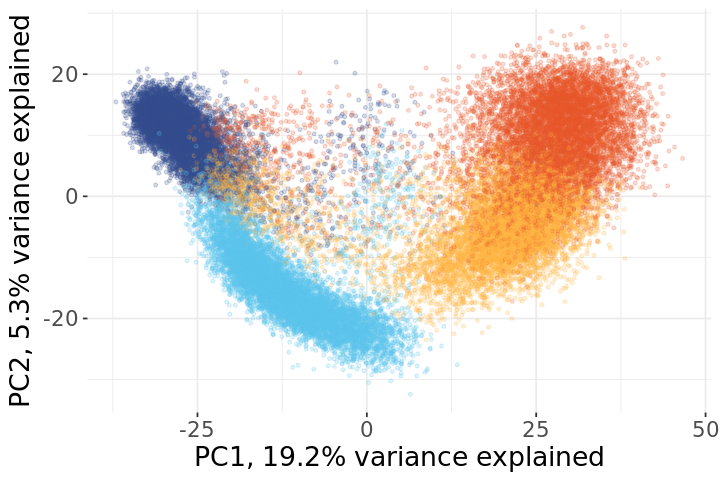

In [12]:
## PCA by day (Fig. 1C, S6)
perc_var <- round(summary(pca.set)$importance[2,]*100, 1)
p = ggplot(df, aes(x = as.numeric(PC1), y = as.numeric(PC2), colour = as.factor(day)))
p = p + geom_point(alpha = 0.2, size = 0.8) #+ ggtitle("PCA, top 500 hvgs")
p = p + scale_color_canva(palette = "Pool party") 
p = p + theme_bw() + theme(legend.position = "none", panel.border = element_blank(), text = element_text(size = 16))
p = p + xlab(paste0("PC1, ",perc_var[1],"% variance explained")) 
p = p + ylab(paste0("PC2, ",perc_var[2],"% variance explained"))
options(repr.plot.width = 6, repr.plot.height = 4)
p

In [16]:
plot_tsne_day <- function(tsne, sce){
    df = data.frame(comp1 = tsne$Y[,1], comp2 = tsne$Y[,2], day = sce$day)
    p = ggplot(df, aes(x = comp1, y = comp2, colour = as.factor(day)))
    p = p + geom_point(alpha = 0.2, size = 0.8) 
    p = p + scale_color_canva(palette = "Pool party") 
    p = p + theme_bw() + theme(legend.position = "none", panel.border = element_blank())
    p
}

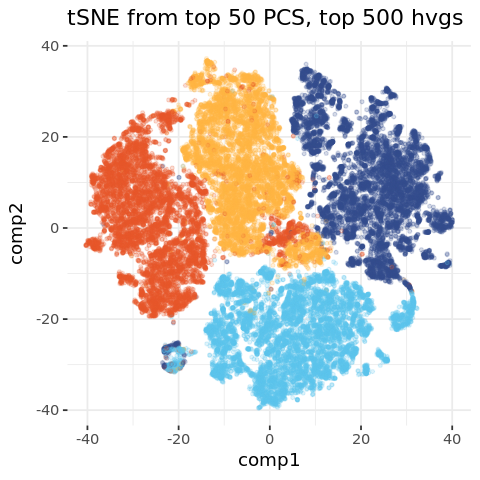

In [17]:
## tSNE by day (Fig. S6)
options(repr.plot.width = 4, repr.plot.height = 4)
plot_tsne_day(tsne.500hvgs, sce[rowData(sce)$is_intop500hvg,]) + ggtitle("tSNE from top 50 PCS, top 500 hvgs")

In [18]:
########################################################
########### random sub-selection of experimental batches

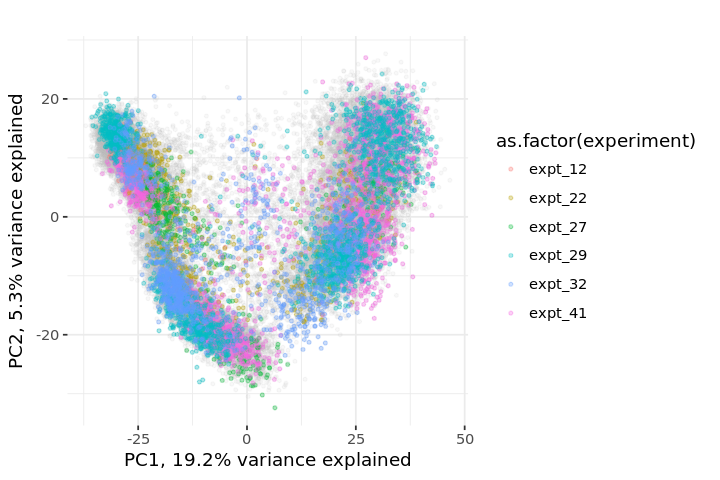

In [19]:
## PCA by experiment (Fig. S16)
set.seed(140792)
expts_sel = unique(df$experiment)[sample(length(unique(df$experiment)),6)]
perc_var <- round(summary(pca.set)$importance[2,]*100, 1)
df = data.frame(PC1 = pca.set$x[,1], PC2 = pca.set$x[,2])
df = as.data.frame(cbind(df, colData(sce)))
p = ggplot(df, aes(x = as.numeric(PC1), y = as.numeric(PC2)))
p = p + geom_point(alpha = 0.1, size = 0.8, col = "grey") + ggtitle("")
p = p + geom_point(aes(x = as.numeric(PC1), y = as.numeric(PC2), colour = as.factor(experiment)), size = 0.8,
                  data = df[df$experiment %in% expts_sel,], alpha = 0.3)
p = p + theme_bw() + theme(panel.border = element_blank())
p = p + xlab(paste0("PC1, ",perc_var[1],"% variance explained")) 
p = p + ylab(paste0("PC2, ",perc_var[2],"% variance explained"))
options(repr.plot.width = 6, repr.plot.height = 4)
p

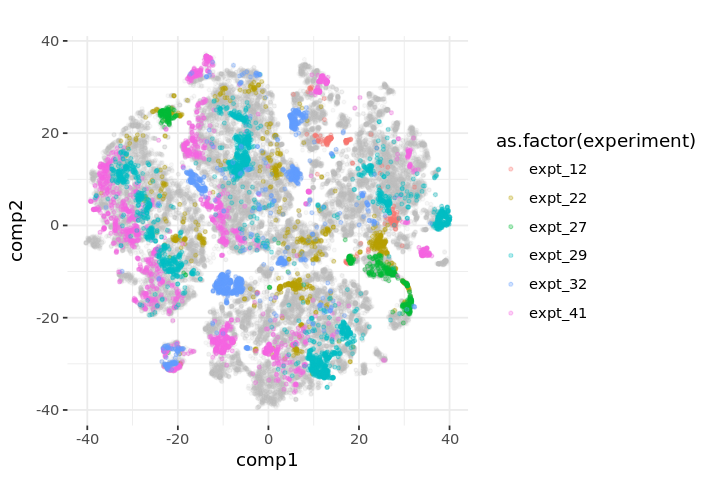

In [20]:
## tSNE by experiment (Fig. S16)
df = data.frame(comp1 = tsne.500hvgs$Y[,1], comp2 = tsne.500hvgs$Y[,2], day = sce$day)
df = as.data.frame(cbind(df, colData(sce)))
p = ggplot(df, aes(x = comp1, y = comp2))
p = p + geom_point(alpha = 0.1, size = 0.8, col = "grey") + ggtitle("")
p = p + geom_point(aes(x = comp1, y = comp2, colour = as.factor(experiment)), size = 0.8,
                  data = df[df$experiment %in% expts_sel,], alpha = 0.3)
p = p + theme_bw() + theme(panel.border = element_blank())
p = p + xlab("comp1") + ylab("comp2")
options(repr.plot.width = 6, repr.plot.height = 4)
p

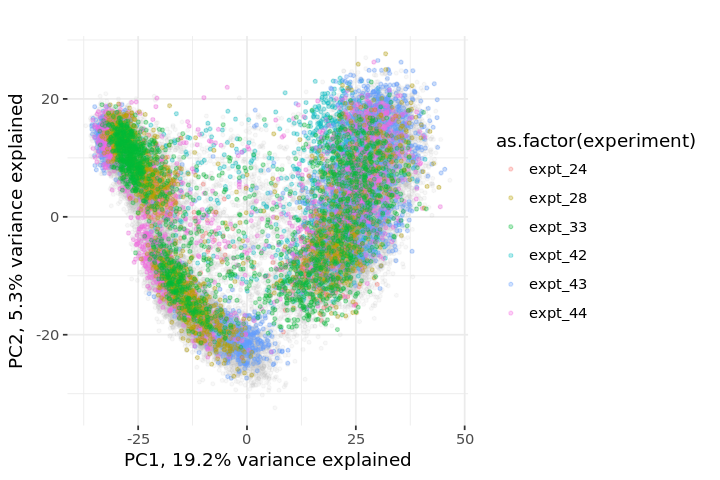

In [21]:
pca.set = pca.500hvgs
df = data.frame(PC1 = pca.set$x[,1], PC2 = pca.set$x[,2], day = sce$day)
df = as.data.frame(cbind(df, colData(sce)))
set.seed(3892)
expts_sel = unique(df$experiment)[sample(length(unique(df$experiment)),6)]
perc_var <- round(summary(pca.set)$importance[2,]*100, 1)
p = ggplot(df, aes(x = as.numeric(PC1), y = as.numeric(PC2)))
p = p + geom_point(alpha = 0.1, size = 0.8, col = "grey") + ggtitle("")
p = p + geom_point(aes(x = as.numeric(PC1), y = as.numeric(PC2), colour = as.factor(experiment)), size = 0.8,
                  data = df[df$experiment %in% expts_sel,], alpha = 0.3)
p = p + theme_bw() + theme(panel.border = element_blank())
p = p + xlab(paste0("PC1, ",perc_var[1],"% variance explained")) 
p = p + ylab(paste0("PC2, ",perc_var[2],"% variance explained"))
options(repr.plot.width = 6, repr.plot.height = 4)
p

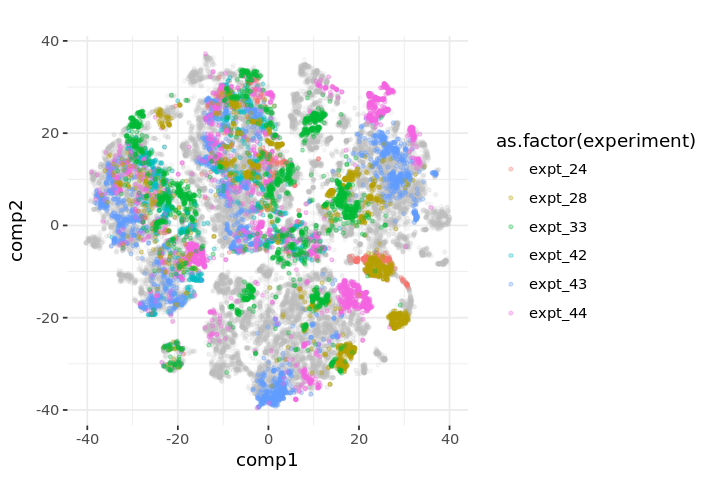

In [22]:
df = data.frame(comp1 = tsne.500hvgs$Y[,1], comp2 = tsne.500hvgs$Y[,2], day = sce$day)
df = as.data.frame(cbind(df, colData(sce)))
p = ggplot(df, aes(x = comp1, y = comp2))
p = p + geom_point(alpha = 0.1, size = 0.8, col = "grey") + ggtitle("")
p = p + geom_point(aes(x = comp1, y = comp2, colour = as.factor(experiment)), size = 0.8,
                  data = df[df$experiment %in% expts_sel,], alpha = 0.3)
p = p + theme_bw() + theme(panel.border = element_blank())
p = p + xlab("comp1") + ylab("comp2")
options(repr.plot.width = 6, repr.plot.height = 4)
p

In [23]:
##############################################
########### random sub-selection of cell lines

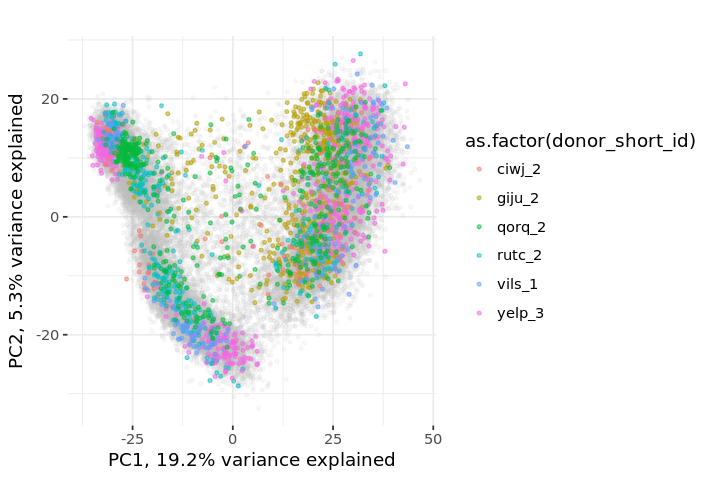

In [24]:
## PCA by donor (Fig. S17)
pca.set = pca.500hvgs
df = data.frame(PC1 = pca.set$x[,1], PC2 = pca.set$x[,2], day = sce$day)
df = as.data.frame(cbind(df, colData(sce)))
set.seed(3892)
donor_sel = unique(df$donor_short_id)[sample(length(unique(df$donor_short_id)),6)]
perc_var <- round(summary(pca.set)$importance[2,]*100, 1)
p = ggplot(df, aes(x = as.numeric(PC1), y = as.numeric(PC2)))
p = p + geom_point(alpha = 0.1, size = 0.8, col = "grey") + ggtitle("")
p = p + geom_point(aes(x = as.numeric(PC1), y = as.numeric(PC2), colour = as.factor(donor_short_id)), size = 0.8,
                  data = df[df$donor_short_id %in% donor_sel,], alpha = 0.5)
p = p + theme_bw() + theme(panel.border = element_blank())
p = p + xlab(paste0("PC1, ",perc_var[1],"% variance explained")) 
p = p + ylab(paste0("PC2, ",perc_var[2],"% variance explained"))
options(repr.plot.width = 6, repr.plot.height = 4)
p

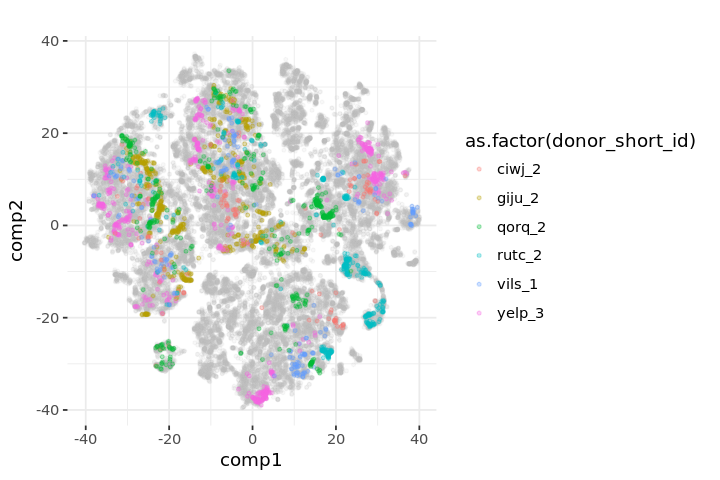

In [25]:
df = data.frame(comp1 = tsne.500hvgs$Y[,1], comp2 = tsne.500hvgs$Y[,2], day = sce$day)
df = as.data.frame(cbind(df, colData(sce)))
p = ggplot(df, aes(x = comp1, y = comp2))
p = p + geom_point(alpha = 0.1, size = 0.8, col = "grey") + ggtitle("")
p = p + geom_point(aes(x = comp1, y = comp2, colour = as.factor(donor_short_id)), size = 0.8,
                  data = df[df$donor_short_id %in% donor_sel,], alpha = 0.3)
p = p + theme_bw() + theme(panel.border = element_blank())
p = p + xlab("comp1") + ylab("comp2")
options(repr.plot.width = 6, repr.plot.height = 4)
p

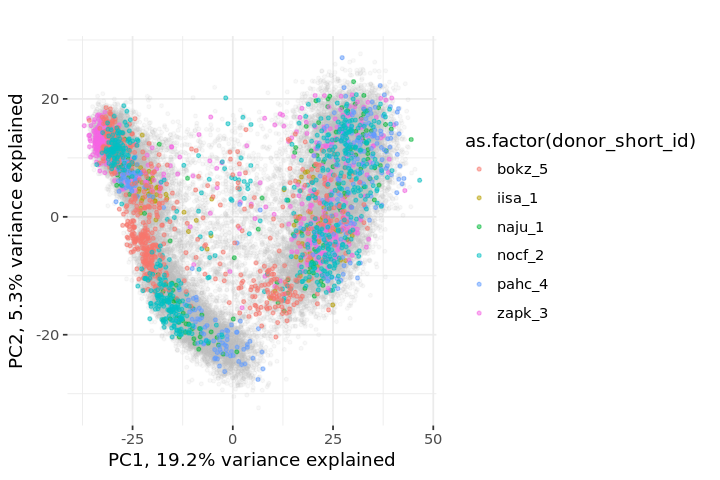

In [26]:
pca.set = pca.500hvgs
df = data.frame(PC1 = pca.set$x[,1], PC2 = pca.set$x[,2], day = sce$day)
df = as.data.frame(cbind(df, colData(sce)))
set.seed(140792)
donor_sel = unique(df$donor_short_id)[sample(length(unique(df$donor_short_id)),6)]
perc_var <- round(summary(pca.set)$importance[2,]*100, 1)
p = ggplot(df, aes(x = as.numeric(PC1), y = as.numeric(PC2)))
p = p + geom_point(alpha = 0.1, size = 0.8, col = "grey") + ggtitle("")
p = p + geom_point(aes(x = as.numeric(PC1), y = as.numeric(PC2), colour = as.factor(donor_short_id)), size = 0.8,
                  data = df[df$donor_short_id %in% donor_sel,], alpha = 0.5)
p = p + theme_bw() + theme(panel.border = element_blank())
p = p + xlab(paste0("PC1, ",perc_var[1],"% variance explained")) 
p = p + ylab(paste0("PC2, ",perc_var[2],"% variance explained"))
options(repr.plot.width = 6, repr.plot.height = 4)
p

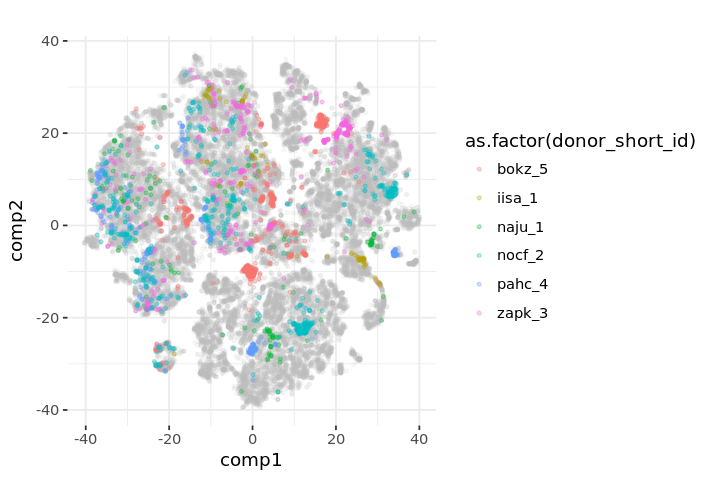

In [27]:
df = data.frame(comp1 = tsne.500hvgs$Y[,1], comp2 = tsne.500hvgs$Y[,2], day = sce$day)
df = as.data.frame(cbind(df, colData(sce)))
p = ggplot(df, aes(x = comp1, y = comp2))
p = p + geom_point(alpha = 0.1, size = 0.8, col = "grey") + ggtitle("")
p = p + geom_point(aes(x = comp1, y = comp2, colour = as.factor(donor_short_id)), size = 0.8,
                  data = df[df$donor_short_id %in% donor_sel,], alpha = 0.3)
p = p + theme_bw() + theme(panel.border = element_blank())
p = p + xlab("comp1") + ylab("comp2")
options(repr.plot.width = 6, repr.plot.height = 4)
p

In [28]:
##############################################
######### neonatal (monongenic) diabetes lines

In [29]:
monogenic_diabetes_lines <- c("dixh_2", "koqx_1", "oebj_1", "eoxi_6", "pulk_1",
                              "fasu_2", "walu_1", "biiw_6", "cekz_1", "tout_1",
                              "fuai_1", "oojs_1", "guyj_2", "eevy_7", "zoio_2", "tach_2")

In [30]:
sce_diabetes = sce[,sce$donor_short_id %in% monogenic_diabetes_lines]

In [31]:
table(sce_diabetes$donor_short_id,sce_diabetes$experiment)

        
         expt_18 expt_20 expt_21 expt_22 expt_23 expt_24 expt_40
  dixh_2       0       0     203       0       0       0       0
  eoxi_6       0       0       0      60       0       0       0
  fasu_2       0      55       0       0       0       0       0
  guyj_2       0       0       0       0     343     128       0
  koqx_1       0       0      58       0       0       0       0
  oebj_1       0       0      37      85       0       0       0
  oojs_1       0       0       0      88       0       0       0
  pulk_1       0       0       0     118     148       0       0
  tout_1       0      22       0       0       0       0     225
  walu_1       0       0       0       0       0      70       0
  zoio_2      67       0       0       0       0       0       0

In [32]:
experiments_with_monogenic_diabetes_lines = unique(sce[,sce$donor_short_id %in% monogenic_diabetes_lines]$experiment)
experiments_with_monogenic_diabetes_lines

[1] "expt_18" "expt_20" "expt_21" "expt_22" "expt_23" "expt_24" "expt_40"

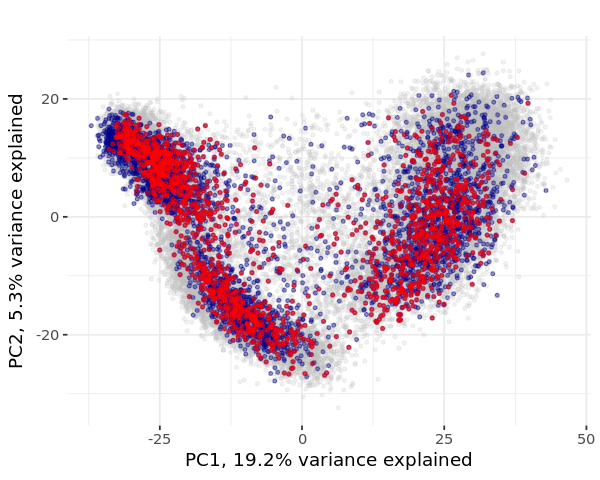

In [33]:
# PCA neonatal diabetes (Fig. S18)
pca.set = pca.500hvgs
perc_var <- round(summary(pca.set)$importance[2,]*100, 1)
df = data.frame(PC1 = pca.set$x[,1], PC2 = pca.set$x[,2])
df = as.data.frame(cbind(df, colData(sce)))
p = ggplot(df, aes(x = as.numeric(PC1), y = as.numeric(PC2)))
p = p + geom_point(alpha = 0.2, size = 0.8, col = "grey") + ggtitle("")
p = p + geom_point(aes(x = as.numeric(PC1), y = as.numeric(PC2)), size = 0.8, col = "darkblue",
                  data = df[df$experiment %in% experiments_with_monogenic_diabetes_lines,], alpha = 0.4)
p = p + geom_point(aes(x = as.numeric(PC1), y = as.numeric(PC2)), size = 0.8,
                  data = df[df$donor_short_id %in% monogenic_diabetes_lines,], alpha = 0.5, col = "red")
p = p + theme_bw() + theme(panel.border = element_blank())
p = p + xlab(paste0("PC1, ",perc_var[1],"% variance explained")) 
p = p + ylab(paste0("PC2, ",perc_var[2],"% variance explained"))
options(repr.plot.width = 5, repr.plot.height = 4)
p

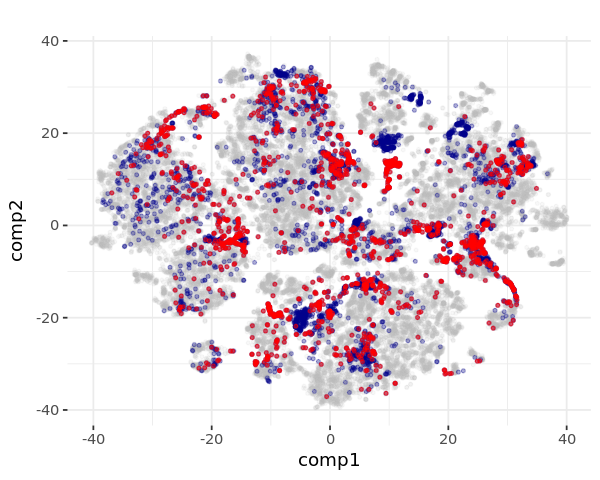

In [34]:
# tSNE neonatal diabetes (Fig. S18)
df = data.frame(comp1 = tsne.500hvgs$Y[,1], comp2 = tsne.500hvgs$Y[,2])
df = as.data.frame(cbind(df, colData(sce)))
p = ggplot(df, aes(x = comp1, y = comp2))
p = p + geom_point(alpha = 0.1, size = 0.8, col = "grey") + ggtitle("")
p = p + geom_point(aes(x = comp1, y = comp2), size = 0.8, col = "darkblue",
                  data = df[df$experiment %in% experiments_with_monogenic_diabetes_lines,], alpha = 0.3)
p = p + geom_point(aes(x = comp1, y = comp2), size = 0.8,
                  data = df[df$donor_short_id %in% monogenic_diabetes_lines,], alpha = 0.5, col = "red")
p = p + theme_bw() + theme(panel.border = element_blank())
p = p + xlab("comp1") + ylab("comp2")
options(repr.plot.width = 5, repr.plot.height = 4)
p